Kinematics of  VFTS 682

In [87]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import sys
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/')
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/')
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatch
from matplotlib.collections import PatchCollection
#from plot_defaults import *
#from termcolor import colored
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import aplpy


In [83]:
# Load data Gaia DR2 for VFTS682
# GAIA ID: 4657685637907503744, retrieved using the Vizier interface

mu_ra = 1.8429766110812542  # marcsec/yr 
err_mu_ra = 0.06974150031513375  # marcsec/yr

mu_dec =  0.7855134899438113  # marcsec/yr
err_mu_dec = 0.07997805252521194  # marcsec/yr

# # Radial velocities from Bestenlehner et al. 2011 (http://adsabs.harvard.edu/abs/2011A%26A...530L..14B)
# # from HeII4686
rv = 315     # km/s
err_rv = 15  # km/s

rv_30Dor = 270  # km/s
err_rv_30Dor = 10  # km/s


# # peculiar RV
drv = rv_30Dor - rv  
err_drv = err_rv+err_rv_30Dor

# # Distance, assumed
D = 50e3  # pc

# parallax -- not used
parallax = -0.02213454741230581  # note that it is negative!
e_parallax = 0.043642011613831244

# position on the sky (degrees)
RAvfts682   = 84.73136339876477
e_RAvfts682 = 0.036321212008208974
DEvfts682   = -69.07411071794998
e_DEvfts682 = 0.04825647078875183

In [ ]:
## some functions, most constants come from $MESA_DIR/const/public/const_def.f90
def convertDpc_to_km(D):
    return D*3.086e13

def convertyr_to_sec(T):
    return T*3.1558149984e7

def convertmarcsec_to_rad(alpha):
    return alpha*math.pi/(648000000.0)

def prop_motion_to_km_s(mu, D):
    # D needs to be in parsec
    # mu in milliarcsec/yr
    return convertDpc_to_km(D)*(mu/convertyr_to_sec(1))*convertmarcsec_to_rad(1)

def remove_systems(array, ind_to_remove):
    ind_to_keep = np.array(1-ind_to_remove,dtype=bool)
    return array[ind_to_keep]

def min_array(array1, array2):
    if len(array1) != len(array2):
        print colored("arrays have different lengths!giving up...","red")
        return np.nan
    else:
        array = np.zeros(len(array1))
        for i in xrange(len(array1)):
            array[i] = min(array1[i], array2[i])
        return array

## read data files downloaded from vizier
# get filename and header
def getFileData(fname):
    src = np.genfromtxt(fname, comments='#', delimiter='|', filling_values=-99998)
    ff = open(fname,'r')
    for i,line in enumerate(ff):
        if 'RA_ICRS|' in line:
            # print i
            col = line.split('|')
            break
    ff.close()
    print col
    return src, col

# read file
def getData(fname):
    src, col = getFileData(fname)
    
    # proper motion RA
    pmRA = src[:, col.index('pmRA')]
    i_pmRA = pmRA != -99998
    
    e_pmRA = src[:, col.index('e_pmRA')]
    i_e_pmRA = e_pmRA != -99998 
    
    # proper motion DEC
    pmDE = src[:, col.index('pmDE')]
    i_pmDE = pmDE != -99998
    
    e_pmDE = src[:, col.index('e_pmDE')]
    i_e_pmDE = e_pmDE != -99998 

    # parallax
    par = src[:, col.index('Plx')]
    # i_par = par != -99998
    
    e_par = src[:, col.index('e_Plx')]
    # i_e_par = e_par != -9998
    
    # filter parallaxes to remove foreground
    # To be implemented
   
    # positions
    RA = src[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE, col.index('RA_ICRS')]
    e_RA = src[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE, col.index('e_RA_ICRS')]/3.6e6  # note that positions are in degree, but errorbars are in milliarcsec, convert all to degrees
    DE = src[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE, col.index('DE_ICRS')]
    e_DE = src[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE, col.index('e_DE_ICRS')]/3.6e6 
    
    # select data that have "good" (= not nan)  proper motion and corresponding errors only
    # N.B: we don't filter on parallaxes because many LMC stars will not have it!
    # Foreground contamination remains most likely
    pmDE = pmDE[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    pmRA = pmRA[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    e_pmDE = e_pmDE[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    e_pmRA = e_pmRA[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    par = par[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    e_par = e_par[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]


    print "selection routine is removing", len(RA)-np.sum(i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE), "stars"
    
    return pmRA, e_pmRA, pmDE, e_pmDE, RA, e_RA, DE, e_DE, par, e_par


def getAvg(x,y, e_x, e_y):
    # returns the 1/error weighted average
    num_x = np.sum(x/e_x)
    den_x = np.sum(1/e_x)
    avg_x = num_x/den_x

    # now evaluate the error: standard error propagation with the
    Nx = len(x)
    err_avg_x = np.sqrt(Nx)/np.sum(1/e_x)

    # repeat for y component
    num_y = np.sum(y/e_y)
    den_y = np.sum(1/e_y)
    avg_y =  num_y/den_y

    Ny = len(y)
    err_avg_y = np.sqrt(Ny)/np.sum(1/e_y)

    return avg_x, err_avg_x, avg_y, err_avg_y



In [ ]:
fname_around = '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/Lennon_like.tsv'
pmRA_around, e_pmRA_around, pmDE_around, e_pmDE_around, RA_around, e_RA_around, DE_around, e_DE_around, par_around, e_par_around = getData(fname_around) 
# print averages
print "============"
print "Average region around (0.2 deg)"
avg_pmRA_around, err_avg_pmRA_around, avg_pmDE_around, err_avg_pmDE_around = getAvg(pmRA_around,pmDE_around, e_pmRA_around, e_pmDE_around)
print "region average: pm_RA=", avg_pmRA_around,"+/-", err_avg_pmRA_around, "pm_DE=", avg_pmDE_around,"+/-", err_avg_pmDE_around
rel_pm = math.sqrt((mu_ra-avg_pmRA_around)**2+(mu_dec-avg_pmDE_around)**2)
err_rel_pm = (1/(rel_pm))*np.sqrt((((mu_ra-avg_pmRA_around)**2)*((err_mu_ra+err_avg_pmRA_around)**2)+((mu_dec-avg_pmDE_around)**2)*((err_mu_dec+err_avg_pmDE_around)**2)))
rel_pmRA  = mu_ra-avg_pmRA_around
err_rel_pmRA = err_mu_ra+err_avg_pmRA_around
rel_pmDEC = mu_dec-avg_pmDE_around
err_rel_pmDEC = err_mu_dec+err_avg_pmDE_around
print "RELATIVE tangential pm:", rel_pm, "RA:", rel_pmRA, "+\-", err_rel_pmRA, "DEC:", rel_pmDEC, "+/-", err_rel_pmDEC
print "RELATIVE tangential velocity components: RA:", prop_motion_to_km_s(rel_pmRA, D), "+/-", prop_motion_to_km_s(err_rel_pmRA, D) , "DEC", prop_motion_to_km_s(rel_pmDEC, D),"+/-",prop_motion_to_km_s(err_rel_pmDEC, D)
print "RELATIVE tangential velocity", prop_motion_to_km_s(rel_pm, D), "+/-", prop_motion_to_km_s(err_rel_pm,D)
print "number of stars=", len(pmRA_around)
print "============"

In [ ]:
# 3D relative velocity cf. surroundings
def get3Dv(vx,dvx,vy,dvy,vz,dvz):
    v = np.sqrt(vx**2+vy**2+vz**2)
    dv = (1/v)*np.sqrt((vx*dvx)**2+(vy*dvy)**2+(vz*dvz)**2)
    return v, dv


vra = prop_motion_to_km_s(mu_ra-avg_pmRA_around, D)
dvra = prop_motion_to_km_s(err_mu_ra+err_avg_pmRA_around, D)


vdec = prop_motion_to_km_s(mu_dec-avg_pmDE_around, D)
dvdec = prop_motion_to_km_s(err_mu_dec+err_avg_pmDE_around, D)

vr = drv
err = err_drv
v, dv = get3Dv(vra,dvra,vdec,dvdec,vr,err)
print v, "+/-", dv


In [ ]:
def get_parametric_eq_line(X0,Y0,slope,x):
    x = np.array(x,dtype=float)
    y = Y0+slope*(x-X0)
    return y

def get_parametric_eq_line2points(X0,Y0, X1, Y1,x):
    x = np.array(x,dtype=float)
    y = Y0+(x-X0)*(X1-X0)/(Y1-Y0)
    return y
    
def plotVFTS682(ax):
    X0 = RAvfts682
    Y0 = DEvfts682

    # avg_pmRA_R136, err_avg_pmRA_R136, avg_pmDE_R136, err_avg_pmDE_R136

    
    ax.quiver(X0, Y0, mu_ra-avg_pmRA_R136, mu_dec-avg_pmDE_R136, color='r', label='VFTS682', scale=None, units='xy')
    # ax.annotate("shit", xy=(X0,Y0), xytext=(X0+mu_ra,Y0+mu_dec), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.scatter(X0, Y0, color='r', marker='x',lw=3, s=100, zorder=10)
    
    # make error cone
    # ax.quiver(RAvfts682,DEvfts682,mu_ra-err_mu_ra,mu_dec+err_mu_dec, color="m", scale=1, units='xy')
    # ax.quiver(RAvfts682,DEvfts682,mu_ra+err_mu_ra,mu_dec-err_mu_dec, color="g", scale=1, units='xy')

    # xmin, xmax = ax.get_xlim()
    # x = np.linspace(xmin, xmax,20)

    # edge1 = ax.plot(x,get_parametric_eq_line2points(X0,Y0, X0+mu_ra-err_mu_ra, Y0+mu_dec+err_mu_dec, x), color='m')
    # edge2 = ax.plot(x,get_parametric_eq_line2points(X0,Y0, X0+mu_ra+err_mu_ra, Y0+mu_dec-err_mu_dec, x), color='g')
    # ax.fill_between(x,
    #                 get_parametric_eq_line2points(X0,Y0, X0+mu_ra-err_mu_ra, Y0+mu_dec+err_mu_dec, x),
    #                 get_parametric_eq_line2points(X0,Y0, X0+mu_ra+err_mu_ra, Y0+mu_dec-err_mu_dec, x),
    #                 lw=2, color='#808080', alpha=0.2)

    
    
def mkPlot(ax, pmDE, pmRA, DE, RA, color='b', plotpm=True, zorder=0):
    # notation
    x = pmRA
    y = pmDE
    xx = RA
    yy = DE
       
    #where the stars are
    ax.scatter(xx,yy,alpha=0.5, color=color, zorder=zorder)

    # # their proper motion
    if plotpm == True:
        ax.quiver(xx,yy,x,y, zorder=zorder+1, scale=None, units='inches')
    
    # beautification
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # ax.yaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # ax.xaxis.set_major_locator(MultipleLocator(0.2))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))


    ax.set_ylabel(r'$\mathrm{DEC}\ \mathrm{[degrees]}$ ',fontsize=30)
    ax.set_xlabel(r'$\mathrm{RA}\ \mathrm{[degrees]}$',fontsize=30)
    
    ax.tick_params(axis='both', which='major', width=2,
                   length=12, pad=10)
    ax.tick_params(axis='both', which='minor', width=2,
                   length=6, pad=10)
    


In [ ]:
# make main plot of the paper.
# for inset plot beautification
def my_mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

# To do: orientation, load background

def MakeMainPlot(fname_R136, fname_around):
    fig = plt.figure(figsize=(15., 9.))
    gs = gridspec.GridSpec(100,100) 
    ax = plt.subplot(gs[:,:])
    # zx = inset_axes(ax, 3.5, 3.5, bbox_to_anchor=(1.75,0.5), bbox_transform=ax.transAxes) 

    ##### re-load the data, just to be sure
    pmRA_around, e_pmRA_around, pmDE_around, e_pmDE_around, RA_around, e_RA_around, DE_around, e_DE_around, par_around, e_par_around = getData(fname_around) 
    pmRA_R136, e_pmRA_R136, pmDE_R136, e_pmDE_R136, RA_R136, e_RA_R136, DE_R136, e_DE_R136, par_R136, e_par_R136 = getData(fname_R136) 
  
    mkPlot(ax, pmDE_R136, pmRA_R136, DE_R136, RA_R136, color='g', plotpm=False,zorder=10)
    # mkPlot(zx, pmDE_R136, pmRA_R136, DE_R136, RA_R136, color='g', plotpm=False,zorder=10 )
    mkPlot(ax, pmDE_around, pmRA_around, DE_around, RA_around, color='b', plotpm=False, zorder=1)

    # zplot = zx.quiver(RAvfts682, DEvfts682, 0, 0, color='r', label='VFTS682', scale=1, units='xy')
    plotVFTS682(ax)

    # zx.spines['left'].set_linewidth(2)
    # zx.spines['top'].set_linewidth(2)
    # zx.spines['bottom'].set_linewidth(2)
    # zx.spines['right'].set_linewidth(2)
    
    # zx.yaxis.set_major_locator(MultipleLocator(0.02))
    # zx.yaxis.set_minor_locator(MultipleLocator(0.01))
    # zx.xaxis.set_major_locator(MultipleLocator(0.05))
    # zx.xaxis.set_minor_locator(MultipleLocator(0.025))


    # zx.set_ylabel(r'$\mathrm{DEC}\ \mathrm{[degrees]}$ ',fontsize=30)
    # zx.set_xlabel(r'$\mathrm{RA}\ \mathrm{[degrees]}$',fontsize=30)
    
    # zx.tick_params(axis='both', which='major', width=2,
    #               length=12, pad=10)
    # zx.tick_params(axis='both', which='minor', width=2,
    #               length=6, pad=10)

    # x,y = getAvg(RA_R136, DE_R136, e_RA_R136, e_DE_R136)
    # ax.scatter(x,y,color='g', s=100, marker='x', lw=3)


    # # zx.set_xlim(min(RA_R136)-0.01, RAvfts682+0.05)
    # # zx.set_ylim(min(DE_R136)-0.01, DEvfts682+0.01)
    ax.set_xlim(84.2,85.2)
    ax.set_ylim(-69.25,-68.9)
    #ax.arrow(x,y,(RAvfts682-x),(DEvfts682-y),color='b')
    # my_mark_inset(ax, zx, loc1a=2, loc2a=2, loc1b=1, loc2b=1, fc="none",lw=2, ec="k",zorder=11)

    #plt.tight_layout()
    fig.savefig('/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/figures/main_plot.pdf') #, bbox_extra_artists=(zplot,), bbox_inches='tight')


## test
fname_around = '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/10arcmin_aroundVFTS682_noG_visibility_errormu_excess_noise_pmlessthan2.txt'    
fname_R136 = '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/R136a_50arcsec_quality_cut.tsv'
MakeMainPlot(fname_R136, fname_around)    
    

In [ ]:
# plot the surrounding regions in proper motion space
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100) 
ax = plt.subplot(gs[:,:])
fname_around='/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/Lennon_like.tsv'
pmRA_around, e_pmRA_around, pmDE_around, e_pmDE_around, RA_around, e_RA_around, DE_around, e_DE_around, par_around, e_par_around = getData(fname_around) 
avg_pmRA_around, err_avg_pmRA_around, avg_pmDE_around, err_avg_pmDE_around= getAvg(pmRA_around,pmDE_around, e_pmRA_around, e_pmDE_around) # weighted with 1/error

print "# stars surroundings:", len(pmRA_around)

ax.errorbar(pmRA_around, pmDE_around, xerr=e_pmRA_around, yerr=e_pmDE_around, ms=10, lw=0, ecolor='b', elinewidth=2)
ax.errorbar(avg_pmRA_around, avg_pmDE_around, xerr=err_avg_pmRA_around, yerr=err_avg_pmDE_around, color='r', markersize=1000)
ax.set_xlabel("$\mu_\mathrm{RA}$ [marcsec/yr]", fontsize=30)
ax.set_ylabel("$\mu_\mathrm{DE}$ [marcsec/yr]", fontsize=30)
ax.set_title("Generic surroundings", fontsize=30)
ax.text(0.5,0.2,"$1\,\mathrm{marcsec\ yr^{-1}}=250\,\mathrm{km\ s^{-1}}$ at 50\,kpc", fontsize=20, transform=ax.transAxes, ha="center")

ax.scatter(mu_ra, mu_dec, marker='*', c='y', s=100)



In [ ]:
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100) 
ax = plt.subplot(gs[:,:])
ax.set_xlim(84.4,85)
# ax.set_ylim(-69.06-0.02,-69.06-0.01)
#mkPlot(ax, pmDE_R136, pmRA_R136, DE_R136, RA_R136, color='g', plotpm=True)
# mkPlot(ax, pmDE_around[::200], pmRA_around[::200], DE_around[::200], RA_around[::200], color='b', plotpm=True)
plotVFTS682(ax)

plt.show()

In [ ]:
# kinematic age

# get position of the center of R136
x,y = getAvg(RA_R136, DE_R136, e_RA_R136, e_DE_R136)

# per components
dx = RAvfts682 - x # deg
dy = DEvfts682 - y # deg #<- needs to be converted to milliarcsec with factor 3.6e6
time_x = dx*3.6e6/rel_RA_R136 # yr
time_y = dy*3.6e6/rel_DE_R136 #yr
print time_x*1e-6, time_y*1e-6 #Myr

# using projection on the sky
dl = math.sqrt(dx*dx+dy*dy)
dl_dt = math.sqrt(rel_RA_R136*rel_RA_R136+rel_DE_R136*rel_DE_R136) # deg
time_l = dl*3.6e6/dl_dt #yr
print time_l*1e-6 #Myr

# using physical units
dL = dl*D #pc
#dL *= 3.086e13 #km
dv = math.sqrt(prop_motion_to_km_s(rel_RA_R136,D)**2+prop_motion_to_km_s(rel_DE_R136,D)**2) #km/s == pc/Myr
# secyer = 3.1558149984e7 #1year = secyer*seconds
# dv = dv/secyer #km/yr

time_L = dL/dv #yr
print time_L #Myr

# # time
# dt = proj_angular_dist/pm_rel_R136 # year, since pm_rel_R136 is in milliarcsec/yr
# dt *= 1e-6

# dt = (proj_angular_dist*D*3.086e13)/(prop_motion_to_km_s(pm_rel_R136,D))
# 
# dt = dt/secyer


# ax.text(0.5,0.5,r"Flight time $\lesssim$ %0.1f"%float(dt)+r"\,Myr", fontsize=30, transform=ax.transAxes, va="center", ha="center")



INFO: Auto-setting vmin to -2.286e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.479e+01 [aplpy.core]


Traceback (most recent call last):
  File "/scratch/mathieu/anaconda2/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
IOError: [Errno 32] Broken pipe
Logged from file core.py, line 676
Traceback (most recent call last):
  File "/scratch/mathieu/anaconda2/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
IOError: [Errno 32] Broken pipe
Logged from file core.py, line 681


INFO: Auto-setting resolution to 300 dpi [aplpy.core]


Traceback (most recent call last):
  File "/scratch/mathieu/anaconda2/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
IOError: [Errno 32] Broken pipe
Logged from file core.py, line 1725


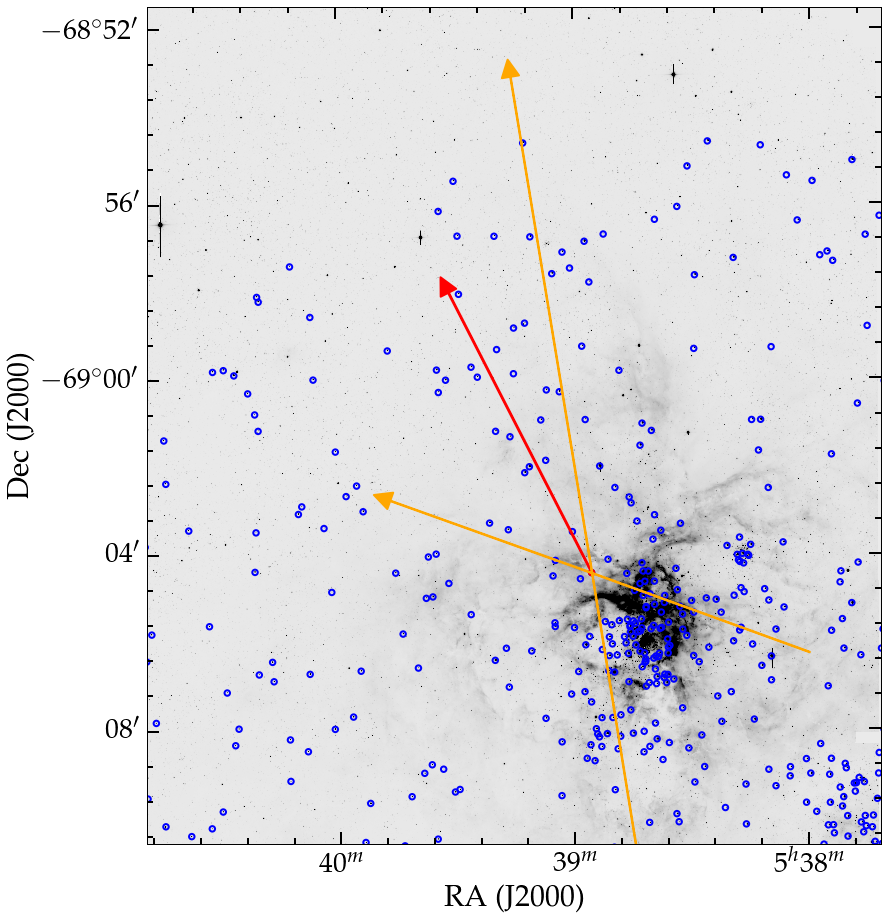

In [103]:
root = '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/figures/ESO_field/'
fitsFileV  = root+'ADP_WFI_30DOR1_V89_V1.0.fits'

ffig = aplpy.FITSFigure(fitsFileV, figsize=(15,15)) #remove downsample=300 for final plot
ffig.show_grayscale(aspect='equal') #possible arg: aspect='auto'

ffig.set_theme('publication')
ffig.ticks.set_linewidth(2)
ffig.ticks.set_length(12)


#cut image on relevant part
xmin, xmax = ffig._ax1.get_xlim()
ffig._ax1.set_xlim(xmax/2.0, xmax)
ymin, ymax = ffig._ax1.get_ylim()
ffig._ax1.set_ylim(ymax/2.0-800, ymax-180)

# ffig._ax1.set_xlim(4500.5, 7000.5) #cut image on y-direction
ffig.tick_labels.set_xformat('hh:mm')
ffig.tick_labels.set_yformat('dd:mm')

ffig.show_markers(RA_around, DE_around, edgecolor='b', lw=2)
ffig.show_markers(RAvfts682, DEvfts682, edgecolor='r', layer='vfts682', lw=2)


# best value
ffig.show_arrows(RAvfts682, DEvfts682, rel_pmRA, rel_pmDEC, color='r', width=5, lw=2,head_length=100, head_width=100,)

# error-cone
ffig.show_arrows(RAvfts682, DEvfts682, rel_pmRA-err_rel_pmRA, rel_pmDEC+err_rel_pmDEC, color='#FFA700',head_length=100, head_width=100, width=3,  lw=2)
ffig.show_arrows(RAvfts682, DEvfts682, rel_pmRA+err_rel_pmRA, rel_pmDEC-err_rel_pmDEC, color='#FFA700',head_length=100, head_width=100, width=3,  lw=2)
# show prolungations in opposite direction
ffig.show_arrows(RAvfts682, DEvfts682, -(rel_pmRA-err_rel_pmRA), -(rel_pmDEC+err_rel_pmDEC), color='#FFA700', head_length=0, head_width=0, width=3,lw=2)
ffig.show_arrows(RAvfts682, DEvfts682, -(rel_pmRA+err_rel_pmRA), -(rel_pmDEC-err_rel_pmDEC), color='#FFA700', head_length=0, head_width=0, width=3, lw=2)

# this one doesn't work
# ax = ffig._ax1.get_ax
# p = mpatch.Wedge((RAvfts682,DEvfts682), r=np.sqrt(rel_pmRA**2+rel_pmDEC**2), theta1=0, theta2=30, color = 'r', transform=ax.transData, zorder=11)
# ax.add_patch(p)

# xmin, xmax = ffig._ax1.get_xlim()
# ymin, ymax = ffig._ax1.get_ylim()


# x1 = xmax#RAvfts682
# x2 = xmin#RAvfts682+rel_pmRA-err_rel_pmRA
# y1 = ymax #DEvfts682
# y2 = ymin #DEvfts682+rel_pmDEC+err_rel_pmDEC

# line_list1 = np.array([[x1, x2],[y1,y2]])
# ffig.show_lines([line_list1], layer=False, zorder=1, alpha=0.5)

ffig.savefig(root+'/../main_plot_good.pdf')